In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12940\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


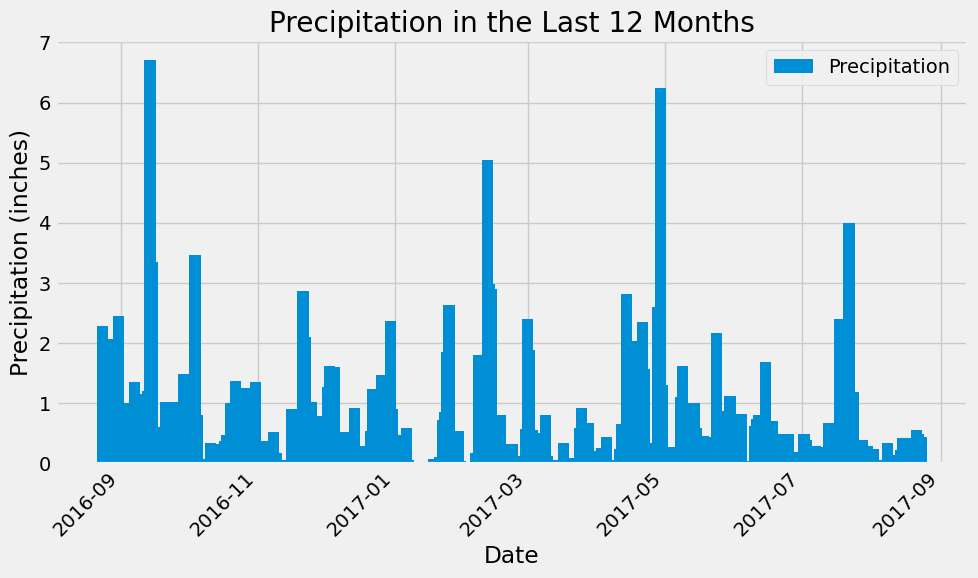

In [10]:
# Calculate the date one year from the last date in the dataset
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df["Date"]=pd.to_datetime(precipitation_df["Date"])
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', width=5)

plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45, ha='right')  
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(precipitation_df['Precipitation'].describe())

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station).label('station_count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Extract the station id from the result
most_active_station_id = most_active_station[0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).first()

print(temperature_stats)

(54.0, 85.0, 71.66378066378067)


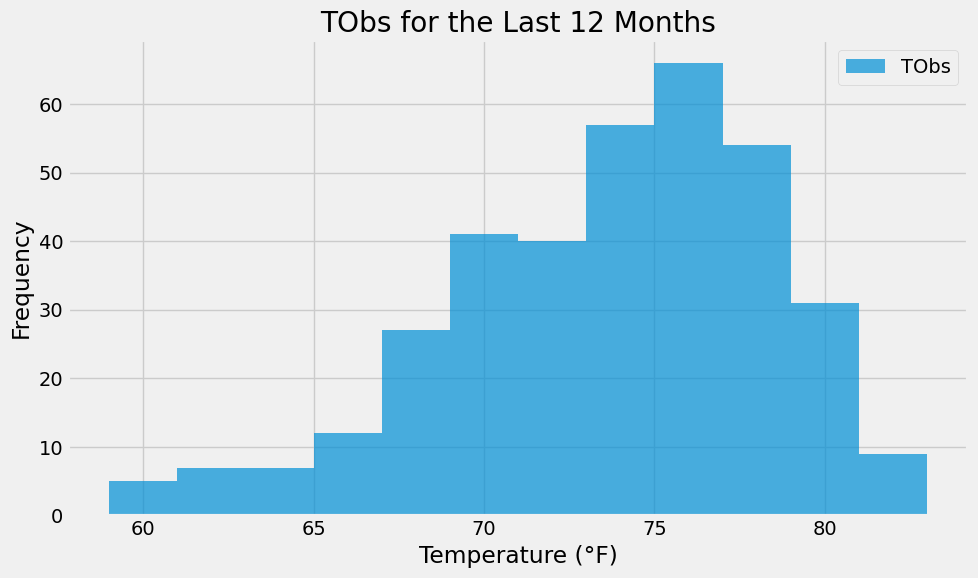

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date_most_active = session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active_station_id).scalar()

# Calculate the date one year from the most recent date
one_year_ago_most_active = dt.datetime.strptime(most_recent_date_most_active, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the temperature observations for the last 12 months for the most active station
temperature_data_most_active = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id,
           Measurement.date >= one_year_ago_most_active).all()


temperature_df_most_active = pd.DataFrame(temperature_data_most_active, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df_most_active['Temperature'], bins=12, label='TObs', alpha=0.7)

plt.title('TObs for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()